# Devoir 3 - Problème 1: Test de modèles linéaires d'évaluation d'actifs

## Partie (a): Importation et exploration des données

Cette section importe les données de Ken French (5 facteurs + momentum + 17 portefeuilles sectoriels) pour la période 1980-2021.

### 1. Importation des modules nécessaires

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Modules importés avec succès!")

Modules importés avec succès!


### 2. Téléchargement des données de Ken French

Nous allons télécharger:
- Les 5 facteurs de Fama-French (F-F_Research_Data_5_Factors_2x3)
- Le facteur Momentum (F-F_Momentum_Factor)
- Les 17 portefeuilles industriels (17_Industry_Portfolios)

In [2]:
import pandas_datareader as pdr
from pandas_datareader.famafrench import get_available_datasets

# Fonction pour télécharger et nettoyer les données de Ken French
def download_french_data(dataset_name, start_date, end_date):
    """
    Télécharge les données de Ken French et retourne un DataFrame nettoyé
    """
    data = pdr.DataReader(dataset_name, 'famafrench', start=start_date, end=end_date)
    # Les données sont retournées comme un dictionnaire de DataFrames
    # On prend généralement le premier élément (données mensuelles)
    df = data[0]
    return df

# Période d'échantillonnage
start_date = '1980-01-01'
end_date = '2021-12-31'

print("Téléchargement des données...")

Téléchargement des données...


In [3]:
# Téléchargement des 5 facteurs de Fama-French
ff5_data = download_french_data('F-F_Research_Data_5_Factors_2x3', start_date, end_date)
print("✓ 5 facteurs Fama-French téléchargés")
print(f"  Shape: {ff5_data.shape}")
print(f"  Colonnes: {list(ff5_data.columns)}")

# Téléchargement du facteur Momentum
mom_data = download_french_data('F-F_Momentum_Factor', start_date, end_date)
print("\n✓ Facteur Momentum téléchargé")
print(f"  Shape: {mom_data.shape}")
print(f"  Colonnes: {list(mom_data.columns)}")

# Téléchargement des 17 portefeuilles industriels
ind17_data = download_french_data('17_Industry_Portfolios', start_date, end_date)
print("\n✓ 17 portefeuilles industriels téléchargés")
print(f"  Shape: {ind17_data.shape}")
print(f"  Colonnes: {list(ind17_data.columns)}")

✓ 5 facteurs Fama-French téléchargés
  Shape: (504, 6)
  Colonnes: ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

✓ Facteur Momentum téléchargé
  Shape: (504, 1)
  Colonnes: ['Mom']

✓ 17 portefeuilles industriels téléchargés
  Shape: (504, 17)
  Colonnes: ['Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum', 'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans', 'Utils', 'Rtail', 'Finan', 'Other']

✓ 17 portefeuilles industriels téléchargés
  Shape: (504, 17)
  Colonnes: ['Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum', 'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans', 'Utils', 'Rtail', 'Finan', 'Other']


### 2.5. Conversion des rendements bruts en excédentaires

Selon la documentation Ken French, les portefeuilles industriels sont en rendements **bruts** (value-weighted). On soustrait donc le taux sans risque (RF) pour obtenir les rendements excédentaires nécessaires à l’analyse des modèles de facteurs.

### 3. Fusion et alignement des données

Nous allons créer un dataset unifié avec les 6 facteurs (5 FF + Momentum) et les 17 portefeuilles industriels.

In [4]:
# Créer le dataset des 6 facteurs en fusionnant FF5 et Momentum
# On garde seulement les 5 facteurs (sans RF pour l'instant)
factors_5 = ff5_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].copy()

# Extraire le momentum (UMD)
momentum = mom_data[['Mom   ']].copy() if 'Mom   ' in mom_data.columns else mom_data.iloc[:, 0].to_frame()
momentum.columns = ['UMD']

# Fusionner pour obtenir les 6 facteurs
factors_6 = pd.concat([factors_5, momentum], axis=1)
factors_6 = factors_6.dropna()

print("Dataset des 6 facteurs créé:")
print(f"  Shape: {factors_6.shape}")
print(f"  Période: {factors_6.index[0]} à {factors_6.index[-1]}")
print(f"  Facteurs: {list(factors_6.columns)}")

# Les portefeuilles industriels sont déjà en rendements excédentaires
industries = ind17_data.copy()
industries = industries.dropna()

print("\nDataset des 17 industries:")
print(f"  Shape: {industries.shape}")
print(f"  Période: {industries.index[0]} à {industries.index[-1]}")
print(f"  Industries: {list(industries.columns)}")

Dataset des 6 facteurs créé:
  Shape: (504, 6)
  Période: 1980-01 à 2021-12
  Facteurs: ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']

Dataset des 17 industries:
  Shape: (504, 17)
  Période: 1980-01 à 2021-12
  Industries: ['Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum', 'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans', 'Utils', 'Rtail', 'Finan', 'Other']


In [12]:
# CORRECTION: Convertir les industries en rendements excédentaires
# Les données de Ken French pour les industries sont en rendements BRUTS
# Nous devons soustraire le taux sans risque (RF)

# Extraire RF
rf = ff5_data['RF'].copy()

# Aligner les données: garder seulement les dates communes
common_index = factors_6.index.intersection(industries.index).intersection(rf.index)
factors_6_aligned = factors_6.loc[common_index]
industries_brut = industries.loc[common_index]
rf_aligned = rf.loc[common_index]

# Convertir les industries en rendements excédentaires: R_excess = R - RF
industries_aligned = industries_brut.subtract(rf_aligned, axis=0)

print(f"✓ Données alignées sur {len(common_index)} périodes mensuelles")
print(f"  Période finale: {common_index[0]} à {common_index[-1]}")
print(f"\n✓ Industries converties en RENDEMENTS EXCÉDENTAIRES (R - RF)")
print(f"  Moyenne RF: {rf_aligned.mean():.3f}%")
print(f"  Impact moyen sur les rendements: -{rf_aligned.mean():.3f}%")
print(f"\nNombre de valeurs manquantes:")
print(f"  Facteurs: {factors_6_aligned.isna().sum().sum()}")
print(f"  Industries: {industries_aligned.isna().sum().sum()}")

# Vérification
print(f"\n✓ Vérification:")
print(f"  Moyenne industries (brut): {industries_brut.mean().mean():.3f}%")
print(f"  Moyenne industries (excédent): {industries_aligned.mean().mean():.3f}%")
print(f"  Différence: {(industries_brut.mean().mean() - industries_aligned.mean().mean()):.3f}%")

✓ Données alignées sur 504 périodes mensuelles
  Période finale: 1980-01 à 2021-12

✓ Industries converties en RENDEMENTS EXCÉDENTAIRES (R - RF)
  Moyenne RF: 0.330%
  Impact moyen sur les rendements: -0.330%

Nombre de valeurs manquantes:
  Facteurs: 0
  Industries: 0

✓ Vérification:
  Moyenne industries (brut): 1.104%
  Moyenne industries (excédent): 0.774%
  Différence: 0.330%


### 4. Statistiques sommaires

Calculons les statistiques descriptives pour tous les facteurs et portefeuilles industriels.

In [13]:
# Statistiques pour les 6 facteurs
print("=" * 80)
print("STATISTIQUES SOMMAIRES - 6 FACTEURS")
print("=" * 80)
stats_factors = factors_6_aligned.describe().T
stats_factors['skew'] = factors_6_aligned.skew()
stats_factors['kurt'] = factors_6_aligned.kurtosis()
print(stats_factors.round(3))

# Statistiques pour les 17 industries
print("\n" + "=" * 80)
print("STATISTIQUES SOMMAIRES - 17 PORTEFEUILLES INDUSTRIELS")
print("=" * 80)
stats_industries = industries_aligned.describe().T
stats_industries['skew'] = industries_aligned.skew()
stats_industries['kurt'] = industries_aligned.kurtosis()
print(stats_industries.round(3))

STATISTIQUES SOMMAIRES - 6 FACTEURS
        count   mean    std    min    25%    50%    75%    max   skew    kurt
Mkt-RF  504.0  0.743  4.476 -23.19 -1.912  1.180  3.482  13.58 -0.704   2.292
SMB     504.0  0.095  2.896 -15.54 -1.588  0.005  1.872  18.46  0.349   4.555
HML     504.0  0.203  3.029 -13.83 -1.505  0.055  1.755  12.24  0.056   2.125
RMW     504.0  0.374  2.404 -18.95 -0.755  0.315  1.372  13.05 -0.438  11.909
CMA     504.0  0.252  1.972  -6.41 -1.020  0.080  1.475   9.01  0.409   1.431
UMD     504.0  0.524  4.479 -34.34 -1.192  0.605  2.840  18.02 -1.318  10.230

STATISTIQUES SOMMAIRES - 17 PORTEFEUILLES INDUSTRIELS
       count   mean    std    min    25%    50%    75%    max   skew   kurt
Food   504.0  0.880  4.176 -18.77 -1.310  0.960  3.422  14.68 -0.378  2.056
Mines  504.0  0.621  7.967 -32.88 -4.623  0.460  5.858  22.47 -0.263  1.221
Oil    504.0  0.643  6.394 -34.78 -2.770  0.760  4.283  32.80  0.056  4.051
Clths  504.0  0.876  6.117 -32.11 -2.200  1.050  4.732  23.

### 5. Graphiques de séries chronologiques

Visualisons l'évolution temporelle de 3 secteurs industriels et 2 facteurs.

Secteurs sélectionnés: ['Food', 'Mines', 'Oil']
Facteurs sélectionnés: ['Mkt-RF', 'UMD']


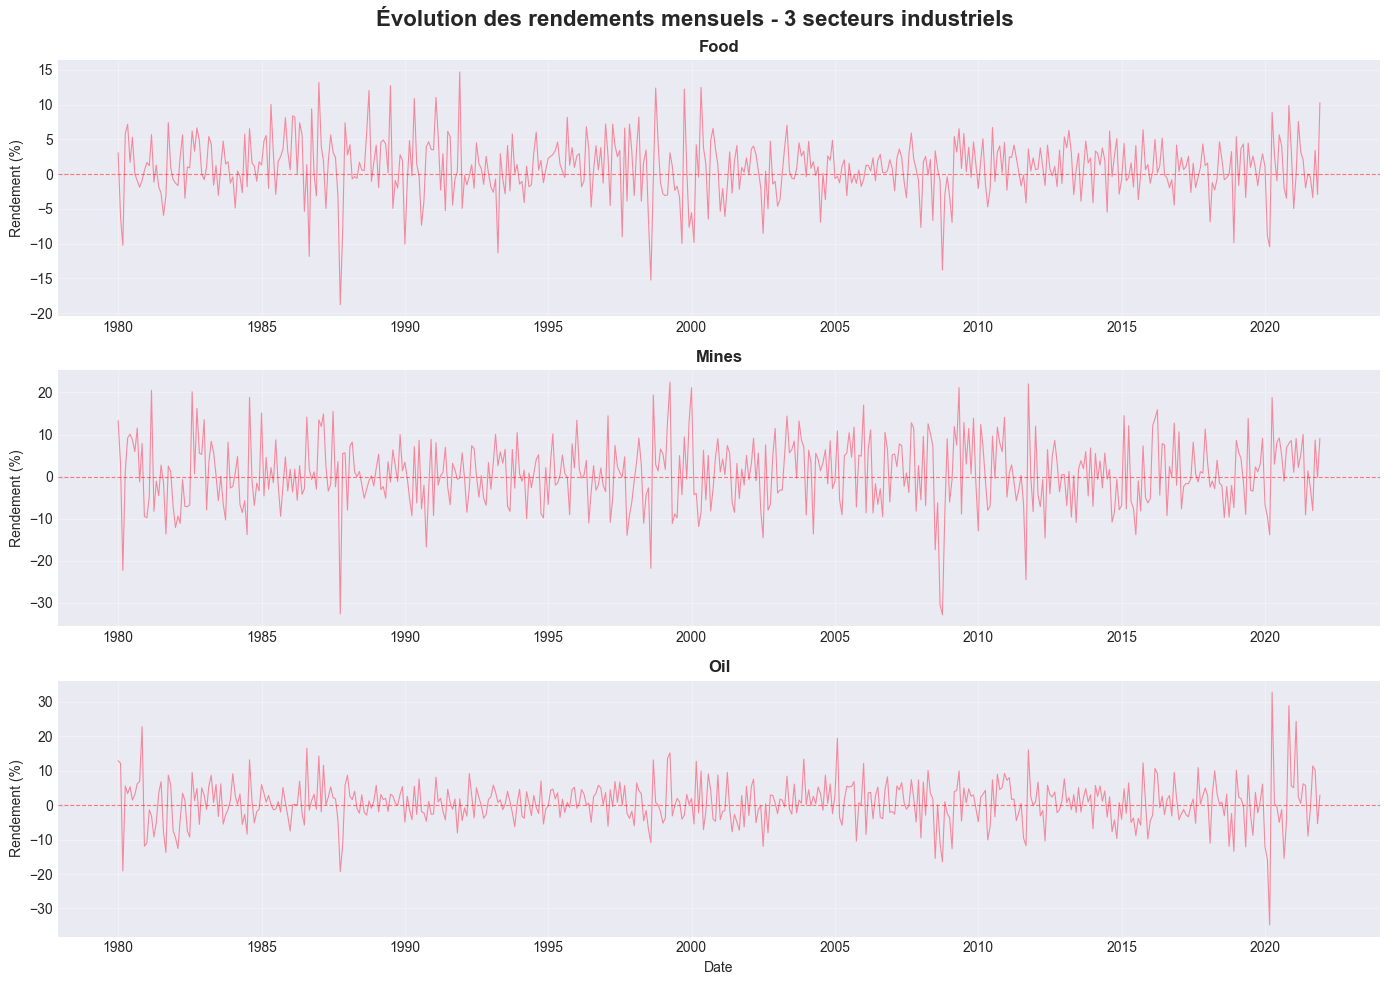

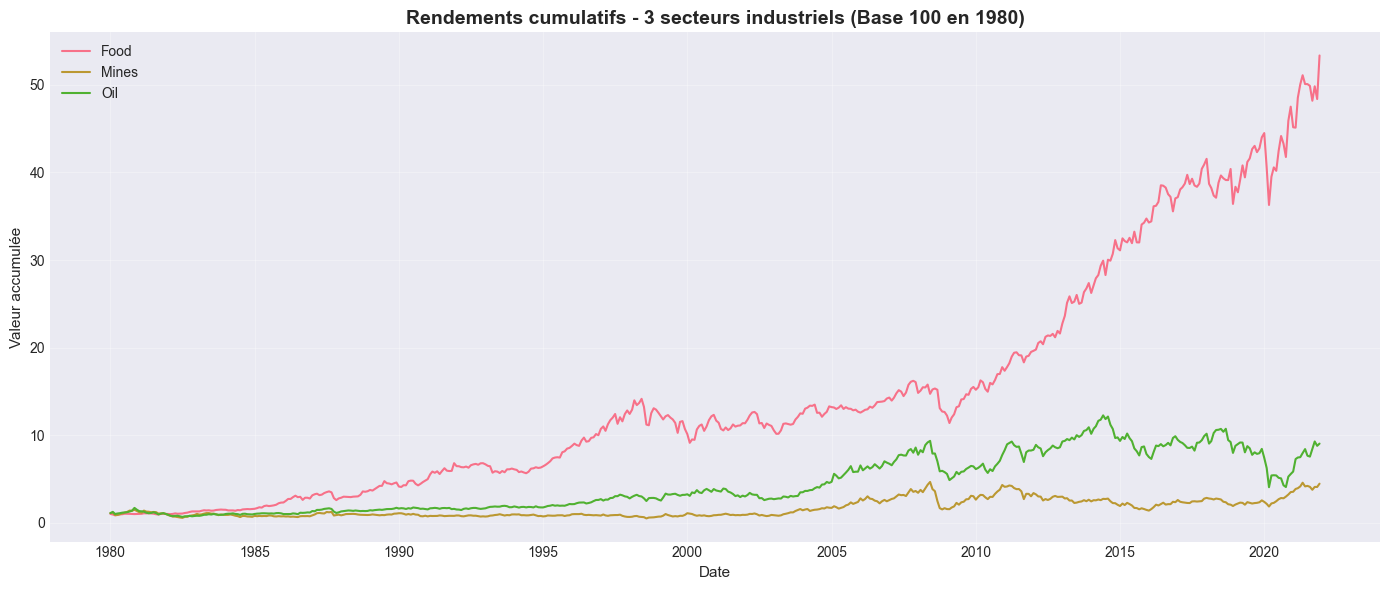

In [14]:
# Sélection de 3 secteurs intéressants (diversifiés)
selected_sectors = industries_aligned.columns[:3]  # On prendra les 3 premiers
print(f"Secteurs sélectionnés: {list(selected_sectors)}")

# Sélection de 2 facteurs (Mkt-RF et Momentum par exemple)
selected_factors = ['Mkt-RF', 'UMD']
print(f"Facteurs sélectionnés: {selected_factors}")

# Convertir l'index en datetime pour matplotlib
dates = industries_aligned.index.to_timestamp()

# Graphique 1: Séries chronologiques des 3 secteurs
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Évolution des rendements mensuels - 3 secteurs industriels', fontsize=16, fontweight='bold')

for i, sector in enumerate(selected_sectors):
    axes[i].plot(dates, industries_aligned[sector], linewidth=0.8, alpha=0.8)
    axes[i].axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
    axes[i].set_title(f'{sector}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Rendement (%)', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    
axes[-1].set_xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

# Calculer et afficher les rendements cumulatifs
cumulative_sectors = (1 + industries_aligned[selected_sectors]/100).cumprod()
fig, ax = plt.subplots(figsize=(14, 6))
for sector in selected_sectors:
    ax.plot(dates, cumulative_sectors[sector], label=sector, linewidth=1.5)
ax.set_title('Rendements cumulatifs - 3 secteurs industriels (Base 100 en 1980)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Valeur accumulée', fontsize=11)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

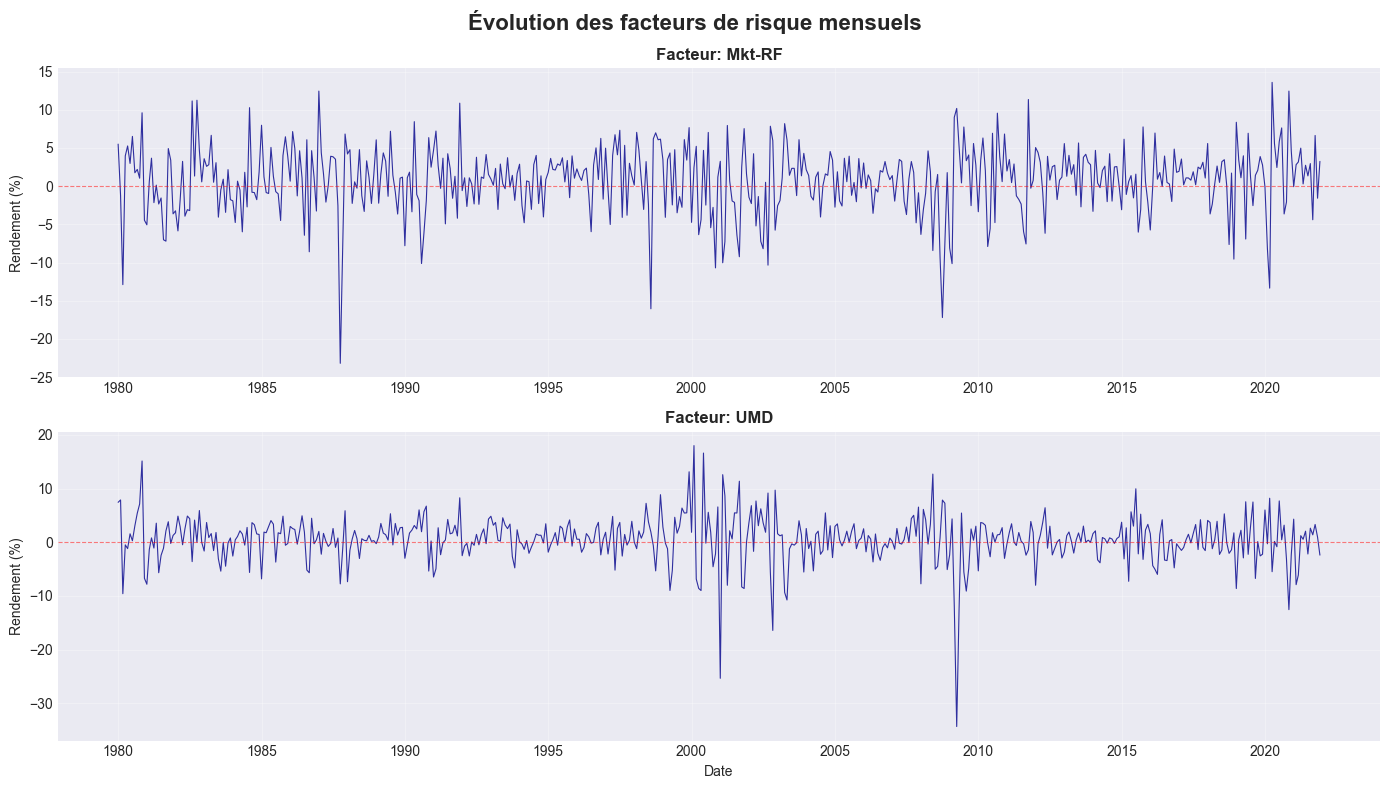

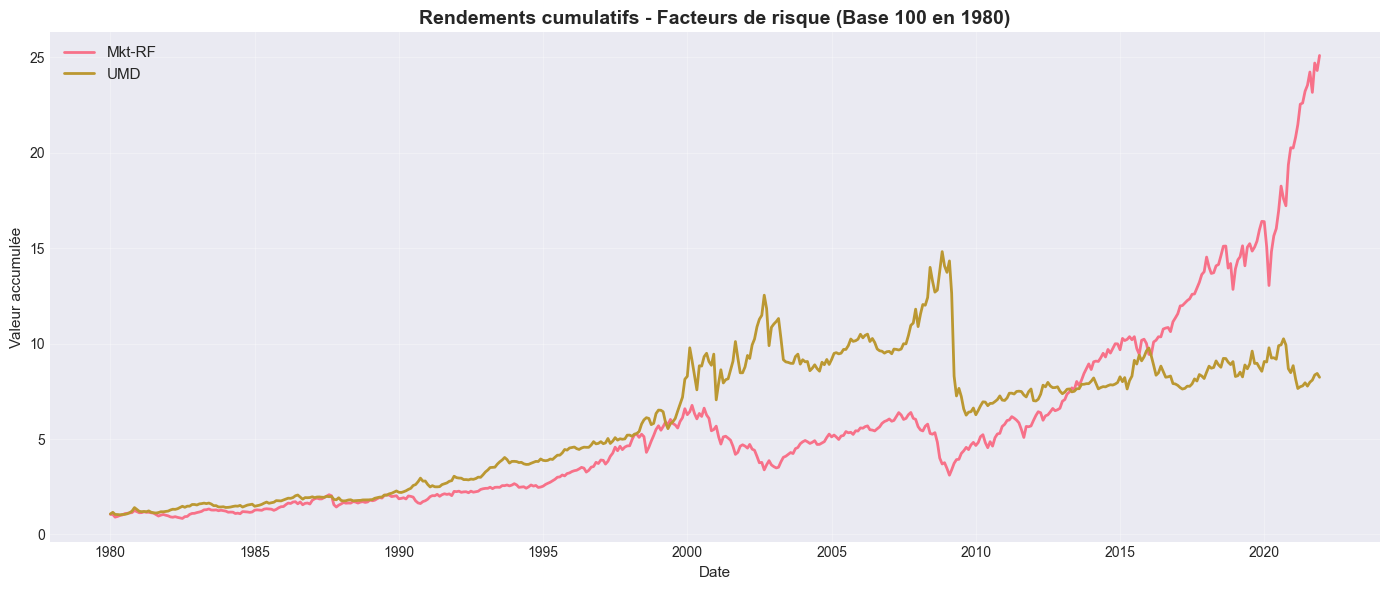

In [15]:
# Convertir l'index en datetime pour les facteurs aussi
dates_factors = factors_6_aligned.index.to_timestamp()

# Graphique 2: Séries chronologiques des 2 facteurs
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
fig.suptitle('Évolution des facteurs de risque mensuels', fontsize=16, fontweight='bold')

for i, factor in enumerate(selected_factors):
    axes[i].plot(dates_factors, factors_6_aligned[factor], linewidth=0.8, alpha=0.8, color='darkblue')
    axes[i].axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
    axes[i].set_title(f'Facteur: {factor}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Rendement (%)', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    
axes[-1].set_xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

# Rendements cumulatifs des facteurs
cumulative_factors = (1 + factors_6_aligned[selected_factors]/100).cumprod()
fig, ax = plt.subplots(figsize=(14, 6))
for factor in selected_factors:
    ax.plot(dates_factors, cumulative_factors[factor], label=factor, linewidth=2)
ax.set_title('Rendements cumulatifs - Facteurs de risque (Base 100 en 1980)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Valeur accumulée', fontsize=11)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6. Discussion des différences notables

Analysons les caractéristiques principales des séries.

In [16]:
print("=" * 80)
print("ANALYSE COMPARATIVE")
print("=" * 80)

# Comparaison des moyennes
print("\n1. RENDEMENTS MOYENS MENSUELS (%):")
print("\nFacteurs:")
print(factors_6_aligned.mean().sort_values(ascending=False).round(3))
print("\nIndustries (top 5 et bottom 5):")
ind_means = industries_aligned.mean().sort_values(ascending=False)
print(ind_means.head(5))
print("...")
print(ind_means.tail(5))

# Comparaison des volatilités
print("\n\n2. VOLATILITÉS (Écart-type en %):")
print("\nFacteurs:")
print(factors_6_aligned.std().sort_values(ascending=False).round(3))
print("\nIndustries (top 5 et bottom 5):")
ind_stds = industries_aligned.std().sort_values(ascending=False)
print(ind_stds.head(5))
print("...")
print(ind_stds.tail(5))

# Ratio de Sharpe annualisé (approximatif, en supposant RF ≈ 0)
print("\n\n3. RATIOS DE SHARPE ANNUALISÉS (approximatifs):")
sharpe_factors = (factors_6_aligned.mean() * 12) / (factors_6_aligned.std() * np.sqrt(12))
print("\nFacteurs:")
print(sharpe_factors.sort_values(ascending=False).round(3))

sharpe_industries = (industries_aligned.mean() * 12) / (industries_aligned.std() * np.sqrt(12))
print("\nIndustries (top 5):")
print(sharpe_industries.sort_values(ascending=False).head(5).round(3))

# Corrélations entre facteurs
print("\n\n4. MATRICE DE CORRÉLATION DES FACTEURS:")
corr_factors = factors_6_aligned.corr()
print(corr_factors.round(3))

ANALYSE COMPARATIVE

1. RENDEMENTS MOYENS MENSUELS (%):

Facteurs:
Mkt-RF    0.743
UMD       0.524
RMW       0.374
CMA       0.252
HML       0.203
SMB       0.095
dtype: float64

Industries (top 5 et bottom 5):
Cars     0.949306
Rtail    0.945714
Cnstr    0.920714
Cnsum    0.884861
Food     0.879683
dtype: float64
...
Utils    0.645873
Oil      0.643214
Mines    0.621488
Durbl    0.606111
Steel    0.495734
dtype: float64


2. VOLATILITÉS (Écart-type en %):

Facteurs:
UMD       4.479
Mkt-RF    4.476
HML       3.029
SMB       2.896
RMW       2.404
CMA       1.972
dtype: float64

Industries (top 5 et bottom 5):
Steel    8.184354
Mines    7.966793
Cars     7.141639
Machn    6.697971
Oil      6.394378
dtype: float64
...
Rtail    5.094841
Other    4.934326
Cnsum    4.311621
Food     4.175876
Utils    3.925489
dtype: float64


3. RATIOS DE SHARPE ANNUALISÉS (approximatifs):

Facteurs:
Mkt-RF    0.575
RMW       0.539
CMA       0.442
UMD       0.406
HML       0.232
SMB       0.114
dtype: float6